In [3]:
%load_ext autoreload
%autoreload 2

from nb_002b import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'cifar10'

In [5]:
data_mean,data_std = map(tensor, ([0.491, 0.482, 0.447], [0.247, 0.243, 0.261]))
cifar_norm = normalize_tfm(mean=data_mean,std=data_std)

In [38]:
tfms = [#flip_lr_tfm(p=0.5),
        pad_tfm(padding=4),
        crop_tfm(size=32, row_pct=(0,1.), col_pct=(0,1.))]

In [39]:
bs = 64

In [41]:
train_ds = FilesDataset(PATH/'train', classes=['airplane','dog'])
valid_ds = FilesDataset(PATH/'test', classes=['airplane','dog'])
data = DataBunch(train_ds, valid_ds, bs=bs, train_tfm=tfms+[cifar_norm], valid_tfm=[cifar_norm], num_workers=0)
len(data.train_dl), len(data.valid_dl)

(157, 16)

## Training loop so far

In [42]:
def loss_batch(model, xb, yb, loss_fn, opt=None):
    loss = loss_fn(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [43]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl):
    for epoch in tnrange(epochs):
        model.train()
        for xb,yb in train_dl:
            loss,_ = loss_batch(model, xb, yb, loss_fn, opt)
            if train_dl.progress_func is not None: train_dl.gen.set_postfix_str(loss)

        model.eval()
        with torch.no_grad():
            losses,nums = zip(*[loss_batch(model, xb, yb, loss_fn)
                                for xb,yb in valid_dl])
        val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)

        print(epoch, val_loss)

In [44]:
class Learner():
    def __init__(self, data, model):
        self.data,self.model = data,model.to(data.device)

    def fit(self, epochs, lr, opt_fn=optim.SGD):
        opt = opt_fn(self.model.parameters(), lr=lr)
        loss_fn = F.cross_entropy
        fit(epochs, self.model, loss_fn, opt, self.data.train_dl, self.data.valid_dl)

## Model

In [45]:
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=conv_layer(ni, ni//2, ks=1)
        self.conv2=conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        layers = [conv_layer(3, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, num_classes)]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x): return self.layers(x)

In [13]:
model = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=16)

## Setting hyperparameters easily

We want an optimizer with an easy way to set hyperparameters: they're all properties and we define custom setters to handle the different names in pytorch optimizers.

In [46]:
class HPOptimizer():
    
    def __init__(self, params, opt_fn, init_lr):
        self.opt = opt_fn(params, init_lr)
        self._lr = init_lr
        self.opt_keys = list(self.opt.param_groups[0].keys())
        self.opt_keys.remove('params')
        self.read_defaults()
    
    #Pytorch optimizer methods
    def step(self):
        self.opt.step()
    
    def zero_grad(self):
        self.opt.zero_grad()
    
    #Hyperparameters as properties
    @property
    def lr(self): return self._lr

    @lr.setter
    def lr(self, val):
        self.set_val('lr', val)
        self._lr = val
    
    @property
    def mom(self): return self._mom

    @mom.setter
    def mom(self, val):
        if 'momentum' in self.opt_keys: self.set_val('momentum', val)
        elif 'betas' in self.opt_keys:  self.set_val('betas', (val, self._beta))
        self._mom = val
    
    @property
    def beta(self): return self._beta

    @beta.setter
    def beta(self, val):
        if 'betas' in self.opt_keys:    self.set_val('betas', (self._mom,val))
        elif 'alpha' in self.opt_keys:  self.set_val('alpha', val)
        self._beta = val
    
    @property
    def wd(self): return self._wd

    @wd.setter
    def wd(self, val):
        self.set_val('weight_decay', val)
        self._wd = val
    
    #Helper functions
    def read_defaults(self):
        if 'momentum' in self.opt_keys: self._mom = self.opt.param_groups[0]['momentum']
        if 'alpha' in self.opt_keys: self._beta = self.opt.param_groups[0]['alpha']
        if 'betas' in self.opt_keys: self._mom,self._beta = self.opt.param_groups[0]['betas']
        if 'weight_decay' in self.opt_keys: self._wd = self.opt.param_groups[0]['weight_decay']
    
    def set_val(self, key, val):
        for pg in self.opt.param_groups: pg[key] = val

In [47]:
opt_fn = partial(optim.Adam, betas=(0.95,0.99))

In [48]:
opt = HPOptimizer(model.parameters(), opt_fn, 1e-2)

In [49]:
opt.lr, opt.mom, opt.wd, opt.beta

(0.01, 0.95, 0, 0.99)

In [50]:
opt.lr=0.2

In [51]:
opt.lr, opt.mom, opt.wd, opt.beta

(0.2, 0.95, 0, 0.99)

Now that it's easy to set and change the HP in the optimizer, we need a scheduler to change it. To keep the training loop as readable as possible we don't want to handle all of this stuff inside it so we'll use callbacks. 

In [52]:
class Callback():
    def on_train_begin(self): pass         
        #To initiliaze constants in the callback.
    def on_epoch_begin(self): pass
        #At the beginning of each epoch
    def on_batch_begin(self, xb, yb): pass 
        #To set HP before the step is done. A look at the input can be useful (set the lr depending on the seq_len in RNNs, 
        #or for reg_functions called in on_backward_begin)
        #Returns xb, yb (which can allow us to modify the input at that step if needed)
    def on_backward_begin(self, loss, out): pass
        #Called after the forward pass and the loss has been computed, but before the back propagation.
        #Passes the loss and the output of the model.
        #Returns the loss (which can allow us to modify it, for instance for reg functions)
    def on_backward_end(self): pass
        #Called after the back propagation had been done (and the gradients computed) but before the step of the optimizer.
        #Useful for true weight decay in AdamW
    def on_step_end(self): pass
        #Called after the step of the optimizer but before the gradients are zeroed (not sure this one is useful)
    def on_batch_end(self, loss): pass
        #Called at the end of the batch
    def on_epoch_end(self, val_loss): pass
        #Called at the end of an epoch
    def on_train_end(self): pass
        #Useful for cleaning up things and saving files/models

The idea is to have a callback between every line of the training loop, that way everything we need to add will be treated there and not inside.

In [53]:
def loss_batch(model, xb, yb, loss_fn, opt=None, callbacks=[]):
    out = model(xb)
    loss = loss_fn(out, yb)

    if opt is not None:
        for cb in callbacks: loss = cb.on_backward_begin(loss, out)
        loss.backward()
        for cb in callbacks: cb.on_backward_end()
        opt.step()
        for cb in callbacks: cb.on_step_end()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [65]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl,callbacks=[]):
    for cb in callbacks: cb.on_train_begin()
    for epoch in tnrange(epochs):
        model.train()
        for cb in callbacks: cb.on_epoch_begin()
        for xb,yb in train_dl:
            for cb in callbacks: xb, yb = cb.on_batch_begin(xb, yb)
            loss,_ = loss_batch(model, xb, yb, loss_fn, opt)
            if train_dl.progress_func is not None: train_dl.gen.set_postfix_str(loss)
            for cb in callbacks: cb.on_batch_end(loss)
            
        model.eval()
        with torch.no_grad():
            losses,nums = zip(*[loss_batch(model, xb, yb, loss_fn)
                                for xb,yb in valid_dl])
        val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
        
        for cb in callbacks: cb.on_epoch_end(val_loss)
        print(epoch, val_loss)
    for cb in callbacks: cb.on_train_end()

First callback: updating the progress bar can be done and printing the validation loss in one. We'll also keep track of the losses and hyper-parameters during training for future plots (lr_finder, plot of the LR/mom schedule).

In [76]:
class Recorder(Callback):
    
    def __init__(self, opt, train_dl=None):
        self.opt,self.train_dl = opt,train_dl
    
    def on_train_begin(self):
        self.epoch = 0
        self.losses,self.val_losses,self.lrs,self.moms = [],[],[],[]
    
    def on_batch_begin(self, xb, yb):
        self.lrs.append(self.opt.lr)
        self.moms.append(self.opt.mom)
        return xb, yb
    
    def on_batch_end(self, loss):
        self.losses.append(loss)
        if self.train_dl is not None and self.train_dl.progress_func is not None: 
            self.train_dl.gen.set_postfix_str(loss)
    
    def on_epoch_end(self, val_loss):
        self.val_losses.append(val_loss)
        print(self.epoch, val_loss)
        self.epoch += 1

In [145]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl=None,callbacks=[]):
    for cb in callbacks: cb.on_train_begin()
    for epoch in tnrange(epochs):
        model.train()
        for cb in callbacks: cb.on_epoch_begin()
        for xb,yb in train_dl:
            for cb in callbacks: xb, yb = cb.on_batch_begin(xb, yb)
            loss,_ = loss_batch(model, xb, yb, loss_fn, opt)
            for cb in callbacks: cb.on_batch_end(loss)
        
        if valid_dl is not None:
            model.eval()
            with torch.no_grad():
                losses,nums = zip(*[loss_batch(model, xb, yb, loss_fn)
                                for xb,yb in valid_dl])
            val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
        else: val_loss = None
        for cb in callbacks: cb.on_epoch_end(val_loss)
        
    for cb in callbacks: cb.on_train_end()

In [146]:
class Learner():
    def __init__(self, data, model):
        self.data,self.model = data,model.to(data.device)
        self.loss_fn, self.opt_fn = F.cross_entropy, optim.SGD

    def fit(self, epochs, lr):
        self.opt = HPOptimizer(self.model.parameters(), self.opt_fn, init_lr=lr)
        self.recorder = Recorder(self.opt, self.data.train_dl)
        fit(epochs, self.model, self.loss_fn, self.opt, self.data.train_dl, self.data.valid_dl, callbacks=[self.recorder])

In [147]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model)

In [148]:
learn.fit(2,0.1)

0 0.6086946115493774


1 0.40670212292671204


This is all very well but what if someone forgets to return xb,yb or the loss in the callbacks that can change it? To be more convenient and make the code of the training loop cleaner, we'll create a class to handle the callbacks.

In [292]:
class CallbackHandler():
    
    def __init__(self, callbacks):
        self.callbacks = callbacks
    
    def on_train_begin(self): 
        for cb in self.callbacks: cb.on_train_begin()
    def on_epoch_begin(self): 
        for cb in self.callbacks: cb.on_epoch_begin()
            
    def on_batch_begin(self, xb, yb):
        for cb in self.callbacks:
            a = cb.on_batch_begin(xb,yb)
            if a is not None: xb,yb = a
        return xb,yb
        
    def on_backward_begin(self, loss, out):
        for cb in self.callbacks:
            a = cb.on_backward_begin(loss, out)
            if a is not None: loss = a
        return loss
    
    def on_backward_end(self): 
        for cb in self.callbacks: cb.on_backward_end()
    def on_step_end(self): 
        for cb in self.callbacks: cb.on_step_end()
       
    def on_batch_end(self, loss):
        stop = False
        for cb in self.callbacks: stop = stop or cb.on_batch_end(loss)
        return stop
            
    def on_epoch_end(self, val_loss):
        stop = False
        for cb in self.callbacks: stop = stop or cb.on_epoch_end(val_loss)
        return stop
    
    def on_train_end(self): 
        for cb in self.callbacks: cb.on_train_end()

In [113]:
def loss_batch(model, xb, yb, loss_fn, opt=None, cb_handler=CallbackHandler([])):
    out = model(xb)
    loss = loss_fn(out, yb)

    if opt is not None:
        loss = cb_handler.on_backward_begin(loss, out)
        loss.backward()
        cb_handler.on_backward_end()
        opt.step()
        cb_handler.on_step_end()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [158]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl=None, callbacks=[]):
    cb_handler = CallbackHandler(callbacks)
    cb_handler.on_train_begin()
    
    for epoch in tnrange(epochs):
        model.train()
        cb_handler.on_epoch_begin()
        
        for xb,yb in train_dl:
            xb, yb = cb_handler.on_batch_begin(xb, yb)
            loss,_ = loss_batch(model, xb, yb, loss_fn, opt, cb_handler)
            if cb_handler.on_batch_end(loss): break
        
        if valid_dl is not None:
            model.eval()
            with torch.no_grad():
                losses,nums = zip(*[loss_batch(model, xb, yb, loss_fn)
                                for xb,yb in valid_dl])
            val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
        else: val_loss=None
        if cb_handler.on_epoch_end(val_loss): break
        
    cb_handler.on_train_end()

In [115]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model)

In [116]:
learn.fit(2,0.1)

0 2.3439104614257813


1 0.4362760104238987


Now we can do a 1cycle scheduler pretty easily.

In [129]:
def annealing_no(start, end, pct): return start
def annealing_linear(start, end, pct): return start + pct * (end-start)
def annealing_exponential(start, end, pct): return start * (end/start) ** pct

In [118]:
class Stepper():
    
    def __init__(self, start, end, num_it, ft):
        self.start,self.end,self.num_it,self.ft = start,end,num_it,ft
        self.n = 0
    
    def step(self):
        self.n += 1
        return self.ft(self.start, self.end, self.n/self.num_it)
    
    def is_done(self):  return self.n >= self.num_it
    def init_val(self): return self.start

In [119]:
class OneCycleScheduler(Callback):
    
    def __init__(self, learn, lr_max, epochs, moms=(0.95,0.85), div_factor=10, pct_end=0.1):
        self.learn = learn
        a = int(len(learn.data.train_dl) * epochs * (1 - pct_end) / 2)
        b = int(len(learn.data.train_dl) * epochs * pct_end)
        self.lr_scheds = [Stepper(lr_max/div_factor, lr_max, a, annealing_linear),
                          Stepper(lr_max, lr_max/div_factor, a, annealing_linear),
                          Stepper(lr_max/div_factor, lr_max/(div_factor*100), b, annealing_linear)]
        self.mom_scheds = [Stepper(moms[0], moms[1], a, annealing_linear),
                          Stepper(moms[1], moms[0], a, annealing_linear),
                          Stepper(moms[0], None, b, annealing_no)]
    
    def on_train_begin(self):
        self.opt = self.learn.opt
        self.opt.lr, self.opt.mom = self.lr_scheds[0].init_val(), self.mom_scheds[0].init_val()
        self.idx_s = 0
    
    def on_batch_end(self, loss):
        self.opt.lr = self.lr_scheds[self.idx_s].step()
        self.opt.mom = self.mom_scheds[self.idx_s].step()
        if self.lr_scheds[self.idx_s].is_done():
            self.idx_s += 1
            if self.idx_s >= len(self.lr_scheds): return True

In [120]:
class Learner():
    def __init__(self, data, model):
        self.data,self.model = data,model.to(data.device)
        self.loss_fn, self.opt_fn = F.cross_entropy, optim.SGD

    def fit(self, epochs, lr, callbacks=[]):
        self.opt = HPOptimizer(self.model.parameters(), self.opt_fn, init_lr=lr)
        self.recorder = Recorder(self.opt, self.data.train_dl)
        cbs = [self.recorder] + callbacks
        fit(epochs, self.model, self.loss_fn, self.opt, self.data.train_dl, self.data.valid_dl, callbacks=cbs)

In [121]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model)
sched = OneCycleScheduler(learn, 0.1, 5)

In [122]:
learn.fit(5,0.1,callbacks=[sched])

0 0.2792151486873627


1 0.2203221492767334


2 0.1535034819841385


3 0.15281309217214584


4 0.12805548286437987


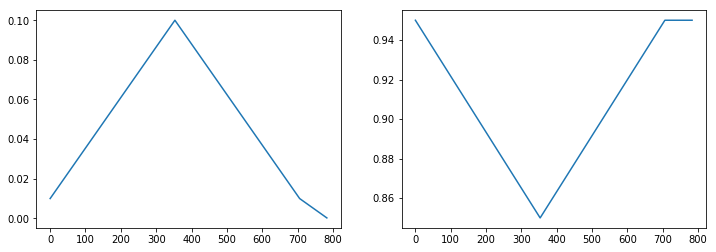

In [128]:
iterations = list(range(len(learn.recorder.lrs)))
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(iterations, learn.recorder.lrs)
axs[1].plot(iterations, learn.recorder.moms)

Or a LR Finder

In [168]:
class LRFinder(Callback):
    
    def __init__(self, learn, start_lr=1e-5, end_lr=10, num_it=200):
        self.learn = learn
        self.sched = Stepper(start_lr, end_lr, num_it, annealing_exponential)
    
    def on_train_begin(self):
        self.opt = self.learn.opt
        self.opt.lr = self.sched.init_val()
        self.stop,self.first,self.best_loss = False,True,0.
    
    def on_batch_end(self, loss):
        if self.first or loss < self.best_loss:
            self.first = False
            self.best_loss = loss
        self.opt.lr = self.sched.step()
        if self.sched.is_done() or loss > 4*self.best_loss: 
            self.stop=True
            return True
    
    def on_epoch_end(self, val_loss): return self.stop

In [169]:
class Learner():
    def __init__(self, data, model):
        self.data,self.model = data,model.to(data.device)
        self.loss_fn, self.opt_fn = F.cross_entropy, optim.SGD

    def fit(self, epochs, lr, callbacks=[], val=True):
        self.opt = HPOptimizer(self.model.parameters(), self.opt_fn, init_lr=lr)
        self.recorder = Recorder(self.opt, self.data.train_dl)
        cbs = [self.recorder] + callbacks
        fit(epochs, self.model, self.loss_fn, self.opt, self.data.train_dl, 
            self.data.valid_dl if val else None, callbacks=cbs)
        
    def lr_find(self, start_lr=1e-5, end_lr=10, num_it=200):
        cb = LRFinder(self, start_lr, end_lr, num_it)
        a = int(np.ceil(num_it/len(self.data.train_dl)))
        self.fit(a, start_lr, callbacks=[cb], val=False)

In [170]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model)

In [171]:
learn.lr_find()

0 None


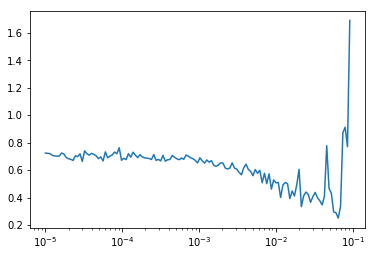

In [172]:
fig, ax = plt.subplots(1,1)
ax.plot(learn.recorder.lrs, learn.recorder.losses)
ax.set_xscale('log')

That's a bit shaky since we plot the loss and not a smoothened version of it. Let's change the recorder so it records a moving average of the loss. We'll also add the plotting functions inside it.

In [299]:
class Recorder(Callback):
    beta = 0.98
    
    def __init__(self, opt, train_dl=None):
        self.opt,self.train_dl = opt,train_dl
    
    def on_train_begin(self):
        self.epoch,self.n,self.avg_loss = 0,0,0.
        self.losses,self.val_losses,self.lrs,self.moms = [],[],[],[]
    
    def on_batch_begin(self, xb, yb):
        self.lrs.append(self.opt.lr)
        self.moms.append(self.opt.mom)
        return xb, yb
    
    def on_backward_begin(self, loss, out):
        #We record the loss here before any other callback has a chance to modify it.
        self.n += 1
        self.avg_loss = self.beta * self.avg_loss + (1-self.beta) * loss.item()
        self.smooth_loss = self.avg_loss / (1 - self.beta ** self.n)
        self.losses.append(self.smooth_loss)
        if self.train_dl is not None and self.train_dl.progress_func is not None: 
            self.train_dl.gen.set_postfix_str(self.smooth_loss)
    
    def on_epoch_end(self, val_loss):
        self.val_losses.append(val_loss)
        print(self.epoch, val_loss)
        self.epoch += 1
    
    def plot_lr(self, show_moms=False):
        iterations = list(range(len(learn.recorder.lrs)))
        if show_moms:
            fig, axs = plt.subplots(1,2, figsize=(12,4))
            axs[0].plot(iterations, self.lrs)
            axs[1].plot(iterations, self.moms)
        else: plt.plot(iterations, self.lrs)
    
    def plot(self, skip_start=10, skip_end=5):
        lrs = self.lrs[skip_start:-skip_end] if skip_end > 0 else self.lrs[skip_start:]
        losses = self.losses[skip_start:-skip_end] if skip_end > 0 else self.losses[skip_start:]
        fig, ax = plt.subplots(1,1)
        ax.plot(lrs, losses)
        ax.set_xscale('log')

In [186]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model)

In [187]:
learn.lr_find()

0 None


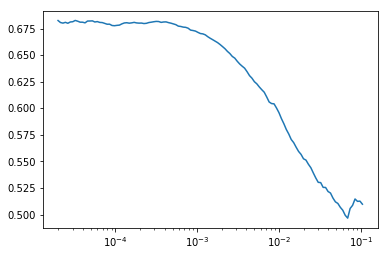

In [191]:
learn.recorder.plot()

To grasp the potential of callbacks, here's a full example:

In [ ]:
class EyeOfSauron(Callback):
    
    def __init__(self, learn):
        #By passing the learner, this callback will have access to everything:
        #All the inputs/outputs as they, the losses, but also the data loaders, the optimizer.
        self.learn = learn
        
        #At any time:
        #Changing self.learn.data.train_dl or self.data.valid_dl will change them inside the fit function
        #(we just need to pass the data object to the fit function and not data.train_dl/data.valid_dl)
        #Changing self.learn.opt.opt (We have an HPOptimizer on top of the actual optimizer) will change it 
        #inside the fit function.
        #Changing self.learn.data or self.learn.opt directly WILL NOT change the data or the optimizer inside the fit function.

    def on_train_begin(self):
        #Here we can initiliaze anything we need. 
        self.opt = self.learn.opt
        #The optimizer has now been initialized. We can change any hyper-parameters by typing
        #self.opt.lr = new_lr, self.opt.mom = new_mom, self.opt.wd = new_wd or self.opt.beta = new_beta
        
    def on_epoch_begin(self):
        #This is not technically useful since we have on_train_begin for epoch 0 and on_epoch_end for all the other epochs
        #yet it makes writing code that needs to be done at the beginning of every epoch easy.
        
    def on_batch_begin(self, xb, yb):
        #If we need to access anything inside the input or target for here or later, we can just save them.
        self.xb,self.yb = xb,yb
        #Here is the perfect place to prepare everything before the model is called.
        #Example: change the values of the hyperparameters (if we don't do it on_batch_end instead)
        
        #If we return something, that will be the new value for xb,yb. 
        
    def on_backward_begin(self, loss, out):
        #If we need the loss or the output of the model for here or later, we can just save them.
        self.raw_loss,self.out = loss,out
        #Here is the place to run some code that needs to be executed after the loss has been computed but before the
        #gradient computation.
        #Example: reg_fn in RNNs.
        
        #If we return something, that will be the new value for loss. Since the recorder is always called first,
        #it will have the raw loss.
        
    def on_backward_end(self):
        #Here is the place to run some code that needs to be executed after the gradients have been computed but
        #before the optimizer is called.
        #Example: deal with weight_decay in AdamW
        
    def on_step_end(self): 
        #Here is the place to run some code that needs to be executed after the optimizer step but before the gradients
        #are zeroed
        #Example: can't thnk of any but maybe someone will need this one day/
        
    def on_batch_end(self, loss):
        #We get the loss again, this time it's the version modified by all the callbacks, so depending on our
        #needs it might be best to use self.raw_loss
        self.loss = loss
        #Here is the place to run some code that needs to be executed after a batch is fully done.
        #Example: change the values of the hyperparameters (if we don't do it on_batch_begin instead)
        
        #If we return true, the current epoch is interrupted (example: lr_finder stops the training when the loss explodes)
        
    def on_epoch_end(self, val_loss):
        #We get the validation loss (TODO: and metrics)
        self.val_loss = val_loss
        #Here is the place to run some code that needs to be executed at the end of an epoch.
        #Example: Save the model if we have a new best validation loss/metric.
        
        #If we return true, the training stops (example: early stopping)
        
    def on_train_end(self): 
        #Here is the place to tidy everything.
        #Examples: save log_files, load best model found during training

Final fit function

In [293]:
def loss_batch(model, xb, yb, loss_fn, opt=None, cb_handler=CallbackHandler([])):
    out = model(xb)
    loss = loss_fn(out, yb)
    
    if opt is not None:
        loss = cb_handler.on_backward_begin(loss, out)
        loss.backward()
        cb_handler.on_backward_end()
        opt.step()
        cb_handler.on_step_end()
        opt.zero_grad()
        
    return loss.item(), len(xb)

def fit(epochs, model, loss_fn, opt, data, callbacks=[]):
    
    cb_handler = CallbackHandler(callbacks)
    cb_handler.on_train_begin()
    
    for epoch in tnrange(epochs):
        model.train()
        cb_handler.on_epoch_begin()
        
        for xb,yb in data.train_dl:
            xb, yb = cb_handler.on_batch_begin(xb, yb)
            loss,_ = loss_batch(model, xb, yb, loss_fn, opt, cb_handler)
            if cb_handler.on_batch_end(loss): break
        
        if hasattr(data,'valid_dl') and data.valid_dl is not None:
            model.eval()
            with torch.no_grad():
                losses,nums = zip(*[loss_batch(model, xb, yb, loss_fn)
                                for xb,yb in data.valid_dl])
            val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
        else: val_loss=None
        if cb_handler.on_epoch_end(val_loss): break
        
    cb_handler.on_train_end()

The idea is that one thing is entirely done in a callback so that it's easily read. For instance let's take back the LRFinder: on top of running the fit function with exponentially growing lrs, it needs to handle the fact some preparation and clean-up, and all this code should be in the callback, not the lr_find function.

In [294]:
class LRFinder(Callback):
    #TODO: add model.save in init or on_train_begin and model.load in on_train_end.
    
    def __init__(self, learn, start_lr=1e-5, end_lr=10, num_it=200):
        self.learn = learn
        self.sched = Stepper(start_lr, end_lr, num_it, annealing_exponential)
        #To avoid validating if the train_dl has less than num_it batches, we put aside the valid_dl and remove it
        #during the call to fit.
        self.valid_dl = learn.data.valid_dl
        learn.data.valid_dl = None
    
    def on_train_begin(self):
        self.opt = self.learn.opt
        self.opt.lr = self.sched.init_val()
        self.stop,self.first,self.best_loss = False,True,0.
    
    def on_batch_end(self, loss):
        if self.first or loss < self.best_loss:
            self.first = False
            self.best_loss = loss
        self.opt.lr = self.sched.step()
        if self.sched.is_done() or self.learn.recorder.smooth_loss > 4*self.best_loss:
            #We use the smoothed loss to decide on the stopping since it's less shaky.
            self.stop=True
            return True
    
    def on_epoch_end(self, val_loss): return self.stop
    
    def on_train_end(self):
        #Clean up and put back the valid_dl in its place.
        self.learn.data.valid_dl = self.valid_dl

In [300]:
class Learner():
    def __init__(self, data, model):
        self.data,self.model = data,model.to(data.device)
        self.loss_fn, self.opt_fn = F.cross_entropy, optim.SGD

    def fit(self, epochs, lr, callbacks=[]):
        self.opt = HPOptimizer(self.model.parameters(), self.opt_fn, init_lr=lr)
        self.recorder = Recorder(self.opt, self.data.train_dl)
        callbacks.insert(0, self.recorder)
        fit(epochs, self.model, self.loss_fn, self.opt, self.data, callbacks=callbacks)
        
    def lr_find(self, start_lr=1e-5, end_lr=10, num_it=200):
        cb = LRFinder(self, start_lr, end_lr, num_it)
        a = int(np.ceil(num_it/len(self.data.train_dl)))
        self.fit(a, start_lr, callbacks=[cb])

In [301]:
model = Darknet([1, 2, 2, 2, 2], num_classes=2, nf=16)
learn = Learner(data, model)

In [302]:
learn.lr_find()

0 None


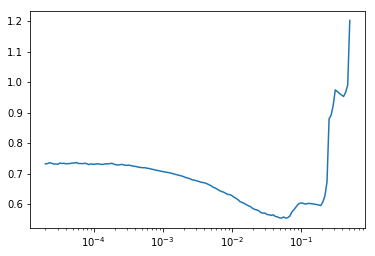

In [298]:
learn.recorder.plot()

In [244]:
len(learn.data.valid_dl)

16

Here are the tests for change of optimizers/dataloaders.

Changing directly opt.opt or data.train_dl/data.valid_dl changes the corresponding item in the fit function.

In [202]:
data = DataBunch(train_ds, valid_ds, bs=bs, train_tfm=tfms+[cifar_norm], valid_tfm=[cifar_norm], num_workers=0)
data1 = DataBunch(train_ds, valid_ds, bs=32, train_tfm=tfms+[cifar_norm], valid_tfm=[cifar_norm], num_workers=0)

In [209]:
class CbTest():
    def __init__(self, learn, new_data):
        self.learn,self.new_data = learn,new_data
        
    def call_me(self):
        self.learn.data.train_dl = self.new_data.train_dl
        self.learn.data.valid_dl = self.new_data.valid_dl

In [210]:
learn.data = data

In [211]:
cb = CbTest(learn, data1)

In [212]:
def test(data, cb):
    x,y = next(iter(data.train_dl))
    print(x.size())
    cb.call_me()
    x,y = next(iter(data.train_dl))
    print(x.size())

In [213]:
test(learn.data, cb)

torch.Size([64, 3, 32, 32])


torch.Size([32, 3, 32, 32])


In [214]:
learn.opt = HPOptimizer(model.parameters(), optim.SGD, 1e-2)

In [219]:
class CbTest():
    def __init__(self, learn, new_opt):
        self.learn,self.new_opt = learn,new_opt
        
    def call_me(self):
        self.learn.opt.opt = self.new_opt

In [220]:
cb = CbTest(learn, optim.Adam)

In [221]:
def test(opt, cb):
    print(opt.opt)
    cb.call_me()
    print(opt.opt)

In [222]:
test(learn.opt,cb)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)
<class 'torch.optim.adam.Adam'>


Changing directly opt or data doesn't change anything inside the fit function.

In [223]:
data = DataBunch(train_ds, valid_ds, bs=bs, train_tfm=tfms+[cifar_norm], valid_tfm=[cifar_norm], num_workers=0)
data1 = DataBunch(train_ds, valid_ds, bs=32, train_tfm=tfms+[cifar_norm], valid_tfm=[cifar_norm], num_workers=0)

In [224]:
class CbTest():
    def __init__(self, learn, new_data):
        self.learn,self.new_data = learn,new_data
        
    def call_me(self):
        self.learn.data = self.new_data

In [225]:
learn.data = data

In [226]:
cb = CbTest(learn, data1)

In [227]:
def test(data, cb):
    x,y = next(iter(data.train_dl))
    print(x.size())
    cb.call_me()
    x,y = next(iter(data.train_dl))
    print(x.size())

In [228]:
test(learn.data, cb)

torch.Size([64, 3, 32, 32])


torch.Size([64, 3, 32, 32])


In [229]:
learn.opt = optim.SGD

In [230]:
class CbTest():
    def __init__(self, learn, new_opt):
        self.learn,self.new_opt = learn,new_opt
        
    def call_me(self):
        self.learn.opt = self.new_opt

In [231]:
cb = CbTest(learn, optim.Adam)

In [232]:
def test(opt, cb):
    print(opt)
    cb.call_me()
    print(opt)

In [233]:
test(learn.opt,cb)

<class 'torch.optim.sgd.SGD'>
<class 'torch.optim.sgd.SGD'>
